# Associations between microbial presence/absence and patient info

In [1]:
setwd("/mnt/c/git_repos/blood_microbial_signatures")
require(tidyverse)
require(ggplot2)
require(data.table)
require(foreach)
require(RColorBrewer)
require(ggpubr)

Loading required package: tidyverse

Warning message:
“package ‘tidyverse’ was built under R version 4.1.3”
Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0     ✔ purrr   1.0.1
✔ tibble  3.1.8     ✔ dplyr   1.1.0
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 1.0.0
Warning message:
“package ‘ggplot2’ was built under R version 4.1.3”
Warning message:
“package ‘tibble’ was built under R version 4.1.3”
Warning message:
“package ‘tidyr’ was built under R version 4.1.3”
Warning message:
“package ‘readr’ was built under R version 4.1.3”
Warning message:
“package ‘purrr’ was built under R version 4.1.3”
Warning message:
“package ‘dplyr’ was built under R version 4.1.3”
Warning message:
“package ‘stringr’ was built under R version 4.1.3”
Warning messa

### Load  data

In [2]:
X <- fread("results/decontamination/prevalence_RA0.005_read10.csv")
nc <- fread("results/decontamination/curated_n117_global_decontamination_stats.csv")
nc_filt <- nc %>%
    filter(site != "")
X <- X %>% select(all_of(c("npm_research_id", unique(nc$taxa))))
X2 <- X %>% select(all_of(c("npm_research_id", unique(nc_filt$taxa))))
RA_df <- fread("results/decontamination/RA_matrix_n117.global_decontaminated.zeroed.csv")

meta <- fread("data/20210125_v3_release/20210203_all_traits_v3.txt")
meta2 <- fread("data/SG10K_Health_metadata.n10714.16March2021.parsed.csv")

n <- gsub("[^0-9A-Za-z///' ]", " ", colnames(meta))
n <- tolower(n)
n <- gsub(" ", "_", n)
colnames(meta) <- n

# fwrite(meta, "data/20210125_v3_release/20210203_all_traits_v3.parsed.csv")

### Group sites

In [3]:
site_list <- unique(nc$site)
site_list <- site_list[site_list != ""]
site_list

[1] "gut"                 "oral"                "genitourinary tract"
[4] "skin"                "blood"               "respiratory tract"  
[7] "eye"

In [4]:
site_morsels <- foreach(site_name = site_list) %do% {
    taxa_list <- (nc %>% filter(site == site_name))$taxa
    X_site_temp <- X %>%
        column_to_rownames("npm_research_id") %>%
        select(all_of(taxa_list)) %>%
        mutate(combined = rowSums(.), .before = 1)  %>%
        mutate(combined = ifelse(combined > 0, 1, 0)) %>%
        select(combined)

    colnames(X_site_temp) <- site_name
    X_site_temp
}

site_morsels2 <- foreach(site_name = site_list) %do% {
    taxa_list <- (nc %>% filter(site == site_name))$taxa
    X_site_temp <- X2 %>%
        column_to_rownames("npm_research_id") %>%
        select(all_of(taxa_list)) %>%
        mutate(combined = rowSums(.), .before = 1)  %>%
        mutate(combined = ifelse(combined > 0, 1, 0)) %>%
        select(combined)

    colnames(X_site_temp) <- site_name
    X_site_temp
}

X_meta <- bind_cols(site_morsels) %>%
    rownames_to_column("npm_research_id") %>%
    left_join(meta, "npm_research_id") %>%
    left_join(meta2, "npm_research_id") %>%
    filter(date_blood == date_biomarker) %>%
    filter(date_blood != "",
           !is.na(date_blood),
           !is.na(date_biomarker),
           date_biomarker != "") %>%
    as_tibble()

X2_meta <- bind_cols(site_morsels2) %>%
    rownames_to_column("npm_research_id") %>%
    left_join(meta, "npm_research_id") %>%
    left_join(meta2, "npm_research_id") %>%
    filter(date_blood == date_biomarker) %>%
    filter(date_blood != "",
           !is.na(date_blood),
           !is.na(date_biomarker),
           date_biomarker != "") %>%
    as_tibble()

### Add microbial presence column

In [5]:
row_sums <- X %>% 
    column_to_rownames("npm_research_id") %>%
    rowSums()

presence_df <- tibble(npm_research_id = names(row_sums), n_present = row_sums) %>%
    mutate(presence = ifelse(n_present > 0, 1, 0))

X_meta <- X_meta %>%
    left_join(presence_df, "npm_research_id")


row_sums2 <- X2 %>% 
    column_to_rownames("npm_research_id") %>%
    rowSums()

presence_df2 <- tibble(npm_research_id = names(row_sums2), n_present = row_sums2) %>%
    mutate(presence = ifelse(n_present > 0, 1, 0))

X2_meta <- X2_meta %>%
    left_join(presence_df2, "npm_research_id")

### Add unhealthy parameters

HBP: https://www.cdc.gov/bloodpressure/about.htm
Tg: https://www.healthxchange.sg/heart-lungs/heart-disease/how-triglycerides-affect-your-heart#:~:text=Borderline%20high%20%E2%80%94%20150%20to%20199,5.7%20mmol%2FL%20or%20above)
Age: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4282767/#B12

In [6]:
median(X_meta$tc_mmol_l, na.rm = T)

[1] 5.3

`summarise()` has grouped output by 'condition'. You can override using the `.groups` argument.


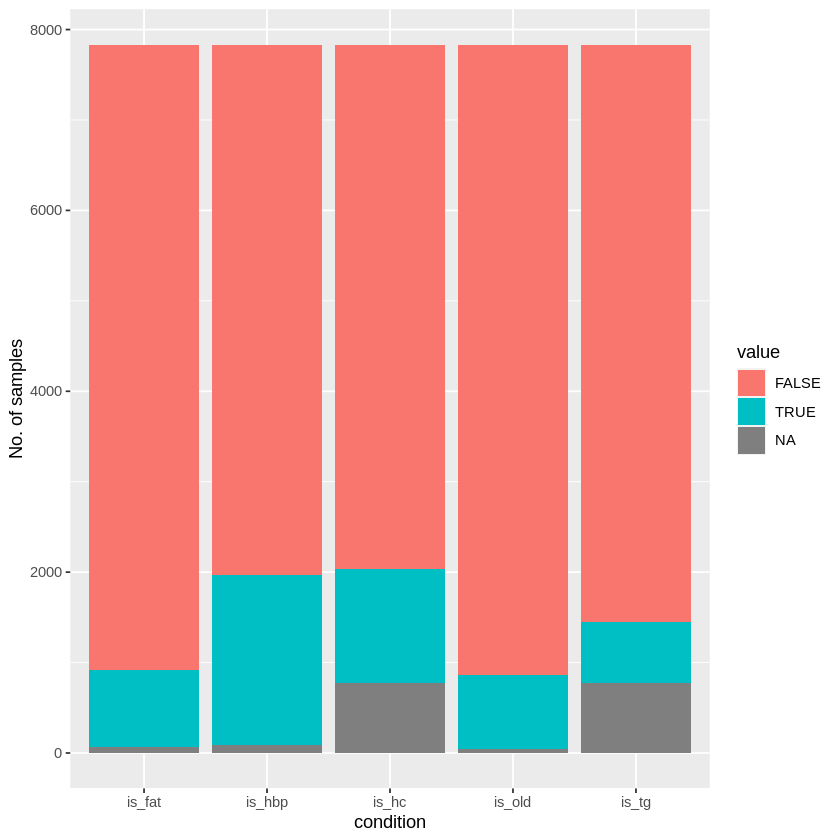

In [7]:
X_parsed <- X_meta %>%
    mutate(is_fat = case_when(is.na(bmi) ~ NA,
                              bmi > 30 ~ T,
                              bmi <= 30 ~ F),
           is_tg = case_when(is.na(tg_mmol_l) ~ NA,
                          tg_mmol_l > 2.3 ~ T,
                          tg_mmol_l <= 2.3 ~ F), 
           is_old = case_when(is.na(age) ~ NA,
                              age >= 65 ~ T,
                              age < 65 ~ F),
           is_hbp = case_when(is.na(sbp) | is.na(dbp) ~ NA,
                              sbp >= 130 & dbp >= 80 ~ T,
                              TRUE ~ F),
           is_hc = case_when(is.na(tc_mmol_l) ~ NA,
                             tc_mmol_l >= 6.2 ~ T,
                             tc_mmol_l < 6.2 ~ F))

X_parsed %>%
    select(is_fat, is_tg, is_old, is_hbp, is_hc) %>%
    pivot_longer(everything(), names_to = "condition", values_to = "value") %>%
    group_by(condition, value) %>%
    summarise(n = n()) %>%
    ggplot(aes(x = condition, y = n, fill = value)) +
    geom_bar(stat = "identity") +
    labs(x = "condition", y = "No. of samples")

In [8]:
var_list <- c("is_fat", "is_old", "is_hbp", "is_tg", "is_hc")

In [9]:
remove_cohorts <- function(X_parsed, var_name) {
    # Remove cohorts with low numbers of phenotype
    to_remove <- X_parsed %>% 
        group_by_at(c(var_name, "site_supplying_sample")) %>%
        summarise(prevalence = sum(presence) / n(), n_pos = sum(presence), n_total = n()) %>%
        filter(n_total < 30,
               !is.na(get(var_name)))

    to_remove <- c(to_remove$site_supplying_sample, "GUSTO", "SSMP")

    X_filt <- X_parsed %>%
        mutate(site_supplying_sample = factor(site_supplying_sample)) %>%
        filter(!is.na(get(var_name)),
               !(site_supplying_sample %in% to_remove))
    return(X_filt)
}

In [10]:
X_parsed

npm_research_id,gut,oral,genitourinary tract,skin,blood,respiratory tract,eye,original_wgs_ids,supplier_id.x,⋯,duplicate.y,duplicate_pair.y,removal_requested_by_supplier,n_present,presence,is_fat,is_tg,is_old,is_hbp,is_hc
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
WHB10753,0,0,0,0,0,0,0,WHB10753,17003-2947,⋯,PASS,Unknown,Unknown,0,0,FALSE,FALSE,FALSE,FALSE,FALSE
WHB9289,0,0,0,0,0,0,0,WHB9289,2572,⋯,PASS,Unknown,Unknown,0,0,TRUE,FALSE,TRUE,FALSE,FALSE
WHB7247,0,0,0,0,0,0,0,WHB7247,17003-1043,⋯,PASS,Unknown,Unknown,0,0,TRUE,FALSE,FALSE,TRUE,FALSE
WHB10124,0,0,0,0,0,0,0,WHB10124,2990,⋯,PASS,Unknown,Unknown,0,0,FALSE,TRUE,TRUE,TRUE,FALSE
WHB8107,0,0,0,0,0,0,0,WHB8107,17003-1903,⋯,PASS,Unknown,Unknown,0,0,TRUE,FALSE,FALSE,TRUE,FALSE
WHB9315,0,0,0,0,0,0,0,WHB9315,2598,⋯,PASS,Unknown,Unknown,0,0,TRUE,FALSE,FALSE,FALSE,FALSE
WHB10904,0,0,0,0,0,0,0,WHB10904,17003-2674,⋯,PASS,Unknown,Unknown,0,0,FALSE,FALSE,FALSE,FALSE,FALSE
WHB8989,0,0,0,0,0,0,0,WHB8989,2252,⋯,PASS,Unknown,Unknown,0,0,FALSE,FALSE,FALSE,FALSE,TRUE
WHH1247,0,0,0,0,0,0,0,WHH1247,CS58089,⋯,PASS,Unknown,Unknown,0,0,FALSE,FALSE,FALSE,FALSE,TRUE


### Fisher's exact test

In [10]:
fisher_morsels <- foreach(var_name = var_list) %do% {
    # Remove cohorts with low numbers of phenotype
    X_filt <- remove_cohorts(X_parsed, var_name)
    cohort_list <- unique(X_filt$site_supplying_sample)
    
    foreach(cohort_name = cohort_list) %do% {
        X_filt2 <- X_filt %>% filter(site_supplying_sample == cohort_name)
        
        obs_test <- fisher.test(X_filt2$presence, deframe(X_filt2[var_name]))
        obs_OR <- obs_test$estimate
        obs_pval <- obs_test$p.value
        n_true <- sum(X_filt2[var_name], na.rm = T)
        n_false <- sum(!X_filt2[var_name], na.rm = T)
        return(tibble(cohort = cohort_name, 
                      variable = var_name, 
                      OR = obs_OR, 
                      p.val = obs_pval,
                      phenotype_breakdown = str_glue("{n_true}T/{n_false}F")))
    }
}

fisher_results <- bind_rows(fisher_morsels)


`summarise()` has grouped output by 'is_fat'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'is_old'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'is_hbp'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'is_tg'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'is_hc'. You can override using the `.groups` argument.


In [11]:
final_results <- fisher_results %>%
    mutate(p.adj = p.adjust(p.val, method = "BH"))
fwrite(final_results, "results/phenotype_associations/derived_phenotype_associations.csv")